# Complete ML Pipeline: Water Quality Prediction
## Train, Validate, Test, and Deploy

This notebook contains the entire machine learning pipeline:
1. Data Loading & Exploration
2. Data Preprocessing
3. Model Training & Cross-Validation
4. Model Validation
5. Hyperparameter Tuning
6. Model Testing
7. Model Export
8. Flask Deployment

## 1. Setup & Imports

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import os
from datetime import datetime

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Display settings
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')
%matplotlib inline

# Random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Data Loading

In [2]:
# Load train, validate, and test data
print("Loading data...")

train_df = pd.read_csv('data/train/train.csv')
validate_df = pd.read_csv('data/validate/validate.csv')
test_df = pd.read_csv('data/test/test.csv')

print(f"Initial Train set: {train_df.shape}")
print(f"Initial Validate set: {validate_df.shape}")
print(f"Initial Test set: {test_df.shape}")

# IDENTIFIED ISSUE: Input y contains NaNs
# Let's identify the target column and drop missing values from target
target_col = train_df.columns[-1]
print(f"\nCleaning target column: {target_col}")

train_df = train_df.dropna(subset=[target_col])
validate_df = validate_df.dropna(subset=[target_col])
test_df = test_df.dropna(subset=[target_col])

print(f"Cleaned Train set: {train_df.shape}")
print(f"Cleaned Validate set: {validate_df.shape}")
print(f"Cleaned Test set: {test_df.shape}")

print(f"\nTotal cleaned samples: {len(train_df) + len(validate_df) + len(test_df)}")

# Display first few rows
print("\nFirst few rows of training data:")
train_df.head()

Loading data...
Initial Train set: (6430, 7)
Initial Validate set: (804, 7)
Initial Test set: (804, 7)

Cleaning target column: Jartest_N_SONG_KN
Cleaned Train set: (6429, 7)
Cleaned Validate set: (804, 7)
Cleaned Test set: (804, 7)

Total cleaned samples: 8037

First few rows of training data:


,NhietdoN_SONG,pH_N_SONG,Duc_N_SONG,Mau_N_SONG,SS_SONG,EC_N_SONG,Jartest_N_SONG_KN
0,28.0,6.8,28.0,163.0,28.0,51.9,16.0
1,30.6,7.2,11.0,NaN,NaN,63.7,18.0
2,29.7,7.0,20.0,NaN,NaN,73.8,18.0
3,29.2,6.9,23.0,233.0,23.0,54.4,18.0
4,29.8,6.9,20.0,185.0,18.0,93.7,18.0


In [3]:
# Check data info
print("Dataset Information:")
print(train_df.info())

print("\nMissing values:")
missing = train_df.isnull().sum()
print(missing[missing > 0])

print("\nBasic statistics:")
train_df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 6429 entries, 0 to 6429
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NhietdoN_SONG      5755 non-null   float64
 1   pH_N_SONG          6388 non-null   float64
 2   Duc_N_SONG         6425 non-null   float64
 3   Mau_N_SONG         2883 non-null   float64
 4   SS_SONG            2451 non-null   float64
 5   EC_N_SONG          6416 non-null   float64
 6   Jartest_N_SONG_KN  6429 non-null   float64
dtypes: float64(7)
memory usage: 401.8 KB
None

Missing values:
NhietdoN_SONG     674
pH_N_SONG          41
Duc_N_SONG          4
Mau_N_SONG       3546
SS_SONG          3978
EC_N_SONG          13
dtype: int64

Basic statistics:


,NhietdoN_SONG,pH_N_SONG,Duc_N_SONG,Mau_N_SONG,SS_SONG,EC_N_SONG,Jartest_N_SONG_KN
count,5755.000000,6388.000000,6425.000000,2883.000000,2451.000000,6416.000000,6429.000000
mean,29.741373,6.880268,36.075541,326.556365,31.480269,68.404802,19.853290
std,1.187390,0.139887,28.696376,273.413234,24.927513,31.851873,4.427709
min,0.620000,6.400000,6.000000,33.000000,1.000000,0.000000,2.000000
25%,28.900000,6.800000,16.000000,134.000000,14.000000,58.000000,18.000000
50%,29.600000,6.900000,25.000000,227.000000,23.000000,62.600000,20.000000
75%,30.500000,7.000000,49.000000,435.500000,42.000000,68.400000,22.000000
max,39.600000,7.500000,228.000000,1956.000000,170.000000,430.000000,38.400000


## 3. Data Preprocessing

In [4]:
# Separate features and target
target_col = train_df.columns[-1]  # Last column is target
feature_cols = train_df.columns[:-1].tolist()

print(f"Target column: {target_col}")
print(f"Feature columns: {feature_cols}")

# Split into X and y
X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_validate = validate_df[feature_cols]
y_validate = validate_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"\n✓ Data split complete")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_validate: {X_validate.shape}, y_validate: {y_validate.shape}")
print(f"  X_test: {X_test.shape}, y_test: {y_test.shape}")

Target column: Jartest_N_SONG_KN
Feature columns: ['NhietdoN_SONG', 'pH_N_SONG', 'Duc_N_SONG', 'Mau_N_SONG', 'SS_SONG', 'EC_N_SONG']

✓ Data split complete
  X_train: (6429, 6), y_train: (6429,)
  X_validate: (804, 6), y_validate: (804,)
  X_test: (804, 6), y_test: (804,)


In [5]:
# Handle missing values with imputation
print("Handling missing values...")

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_validate_imputed = imputer.transform(X_validate)
X_test_imputed = imputer.transform(X_test)

print("✓ Missing values imputed (strategy: mean)")

# Feature scaling
print("\nScaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_validate_scaled = scaler.transform(X_validate_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

print("✓ Features scaled using StandardScaler")

Handling missing values...
✓ Missing values imputed (strategy: mean)

Scaling features...
✓ Features scaled using StandardScaler


## 4. Model Training & Cross-Validation

In [6]:
# Define models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(random_state=RANDOM_STATE),
    'Lasso': Lasso(random_state=RANDOM_STATE),
    'ElasticNet': ElasticNet(random_state=RANDOM_STATE),
    'Random Forest': RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(random_state=RANDOM_STATE)
}

results = []
cv_results_data = []

print("Training and evaluating models...\n")
print("="*80)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Cross-validation on training set
    cv_scores = cross_val_score(
        model, X_train_scaled, y_train,
        cv=5, scoring='r2', n_jobs=-1
    )
    
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # Store CV results for plotting
    for score in cv_scores:
        cv_results_data.append({'Model': name, 'R2 Score': score})
    
    # Train on full training set
    model.fit(X_train_scaled, y_train)
    
    # Evaluate on training set
    train_r2 = model.score(X_train_scaled, y_train)
    
    # Evaluate on validation set
    val_r2 = model.score(X_validate_scaled, y_validate)
    y_val_pred = model.predict(X_validate_scaled)
    val_mae = mean_absolute_error(y_validate, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_validate, y_val_pred))
    
    results.append({
        'Model': name,
        'CV R2 Mean': cv_mean,
        'CV R2 Std': cv_std,
        'Train R2': train_r2,
        'Val R2': val_r2,
        'Val MAE': val_mae,
        'Val RMSE': val_rmse
    })
    
    print(f"  CV R2: {cv_mean:.4f} ± {cv_std:.4f}")
    print(f"  Train R2: {train_r2:.4f}")
    print(f"  Val R2: {val_r2:.4f}")

print("\n" + "="*80)
print("\n✓ All models trained and evaluated")

Training and evaluating models...


Training Linear Regression...


  CV R2: 0.3882 ± 0.0239
  Train R2: 0.3916
  Val R2: 0.3217

Training Ridge...


  CV R2: 0.3882 ± 0.0238
  Train R2: 0.3916
  Val R2: 0.3218

Training Lasso...


  CV R2: 0.2546 ± 0.0162
  Train R2: 0.2554
  Val R2: 0.2586

Training ElasticNet...


  CV R2: 0.2705 ± 0.0118
  Train R2: 0.2714
  Val R2: 0.2706

Training Random Forest...


  CV R2: 0.6010 ± 0.0196
  Train R2: 0.9457
  Val R2: 0.5804

Training Gradient Boosting...


  CV R2: 0.5940 ± 0.0189
  Train R2: 0.6352
  Val R2: 0.5738


✓ All models trained and evaluated


In [7]:
# Display results
results_df = pd.DataFrame(results)
print("Model Comparison:\n")
print(results_df.round(4))

# Identify best model
best_idx = results_df['Val R2'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_val_r2 = results_df.loc[best_idx, 'Val R2']

print(f"\n✓ Best model: {best_model_name} (Val R2: {best_val_r2:.4f})")

Model Comparison:

               Model  CV R2 Mean  CV R2 Std  Train R2  Val R2  Val MAE  \
0  Linear Regression      0.3882     0.0239    0.3916  0.3217   2.6417   
1              Ridge      0.3882     0.0238    0.3916  0.3218   2.6416   
2              Lasso      0.2546     0.0162    0.2554  0.2586   2.8543   
3         ElasticNet      0.2705     0.0118    0.2714  0.2706   2.8206   
4      Random Forest      0.6010     0.0196    0.9457  0.5804   2.1128   
5  Gradient Boosting      0.5940     0.0189    0.6352  0.5738   2.1430   

   Val RMSE  
0    3.7371  
1    3.7370  
2    3.9072  
3    3.8753  
4    2.9393  
5    2.9624  

✓ Best model: Random Forest (Val R2: 0.5804)


## 5. Hyperparameter Tuning

In [8]:
# Define parameter grids for each model
param_grids = {
    'Ridge': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
    'Lasso': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]},
    'ElasticNet': {'alpha': [0.001, 0.01, 0.1, 1.0], 'l1_ratio': [0.2, 0.5, 0.8]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5]},
    'Linear Regression': {}
}

current_param_grid = param_grids.get(best_model_name, {})

if current_param_grid:
    print(f"Tuning hyperparameters for {best_model_name}...")
    
    # Get the base model
    base_model = models[best_model_name]
    
    # Grid search
    grid_search = GridSearchCV(
        base_model, current_param_grid,
        cv=5, scoring='r2',
        n_jobs=-1, verbose=1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    print(f"\n✓ Best parameters: {grid_search.best_params_}")
    print(f"✓ Best CV score: {grid_search.best_score_:.4f}")
    
    best_model = grid_search.best_estimator_
else:
    print(f"No hyperparameters to tune for {best_model_name}")
    best_model = models[best_model_name]
    best_model.fit(X_train_scaled, y_train)

Tuning hyperparameters for Random Forest...
Fitting 5 folds for each of 9 candidates, totalling 45 fits



✓ Best parameters: {'max_depth': 10, 'n_estimators': 200}
✓ Best CV score: 0.6109


## 6. Final Model Evaluation on Test Set

In [9]:
# Evaluate on test set
print("Evaluating final model on test set...\n")

y_test_pred = best_model.predict(X_test_scaled)

# Calculate metrics
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

# Calculate MAPE (avoid division by zero)
mask = y_test != 0
if np.sum(mask) > 0:
    test_mape = np.mean(np.abs((y_test[mask] - y_test_pred[mask]) / y_test[mask])) * 100
else:
    test_mape = np.nan

print("="*80)
print("FINAL MODEL PERFORMANCE ON TEST SET")
print("="*80)
print(f"Model: {best_model_name}")
print(f"R² Score: {test_r2:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAPE: {test_mape:.2f}%")
print("="*80)

Evaluating final model on test set...

FINAL MODEL PERFORMANCE ON TEST SET
Model: Random Forest
R² Score: 0.6206
MAE: 2.0214
RMSE: 2.7133
MAPE: 11.29%


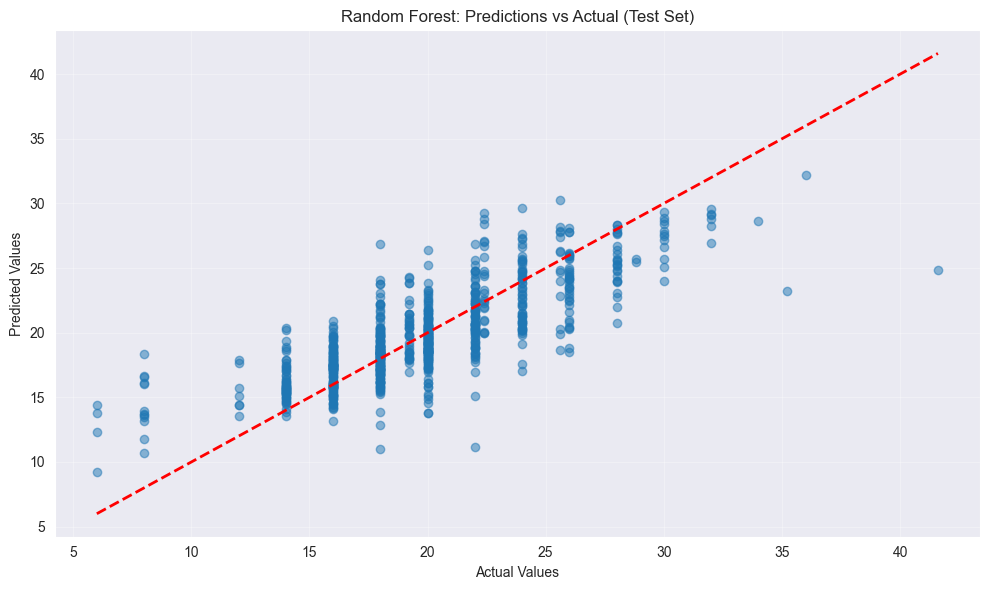

✓ Prediction plot saved to front_end/assets/test_predictions.png


In [10]:
# Visualization: Predictions vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'{best_model_name}: Predictions vs Actual (Test Set)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('front_end/assets/test_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Prediction plot saved to front_end/assets/test_predictions.png")

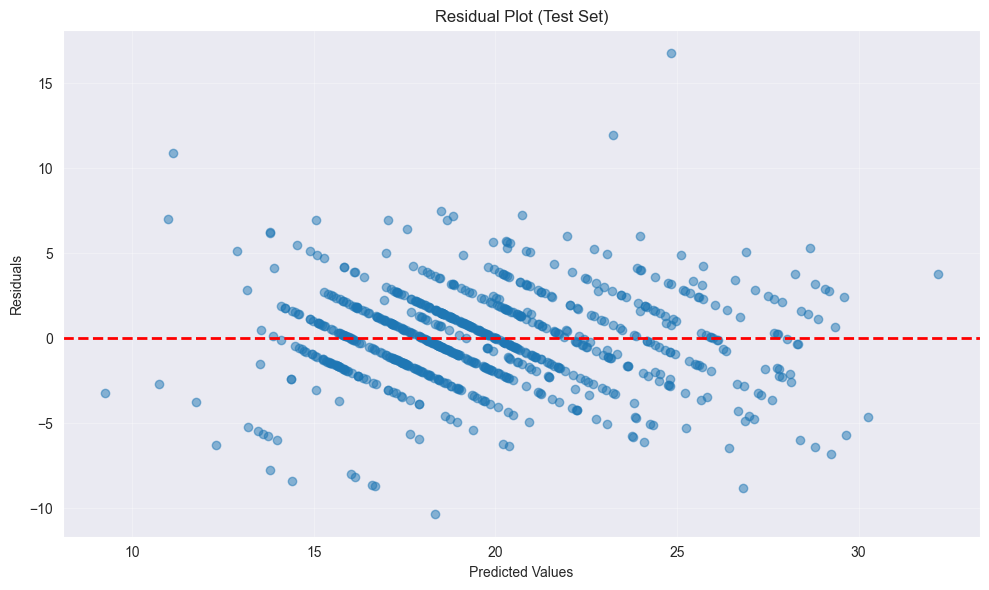

✓ Residual plot saved to front_end/assets/residuals.png


In [11]:
# Visualization: Residuals
residuals = y_test - y_test_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Test Set)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('front_end/assets/residuals.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Residual plot saved to front_end/assets/residuals.png")

## 7. Model Export

In [12]:
# Create model directory
os.makedirs('model', exist_ok=True)

# Save everything in a single file
model_data = {
    'model': best_model,
    'scaler': scaler,
    'imputer': imputer,
    'feature_names': feature_cols,
    'target_name': target_col,
    'model_type': best_model_name,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metrics': {
        'test_r2': float(test_r2),
        'test_mae': float(test_mae),
        'test_rmse': float(test_rmse),
        'test_mape': float(test_mape) if not np.isnan(test_mape) else None,
        'test_accuracy': float(100 - test_mape) if not np.isnan(test_mape) else None
    }
}

model_path = 'model/best_model.pkl'
joblib.dump(model_data, model_path)

print(f"✓ Model saved to {model_path}")
print(f"  Model type: {best_model_name}")
print(f"  Features: {len(feature_cols)}")
print(f"  Test R²: {test_r2:.4f}")

✓ Model saved to model/best_model.pkl
  Model type: Random Forest
  Features: 6
  Test R²: 0.6206


In [13]:
# Save metrics as JSON for easy access
metrics_data = {
    'model_name': best_model_name,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_metrics': {
        'r2_score': float(test_r2),
        'mae': float(test_mae),
        'rmse': float(test_rmse),
        'mape': float(test_mape) if not np.isnan(test_mape) else None,
        'accuracy': float(100 - test_mape) if not np.isnan(test_mape) else None
    },
    'data_split': {
        'train_samples': len(train_df),
        'validate_samples': len(validate_df),
        'test_samples': len(test_df),
        'random_state': RANDOM_STATE
    },
    'features': feature_cols,
    'target': target_col
}

metrics_path = 'model/metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics_data, f, indent=2)

print(f"✓ Metrics saved to {metrics_path}")

✓ Metrics saved to model/metrics.json


## 8. Flask Deployment

Run the cell below to start the Flask server. The API will be available at `http://localhost:5000`

In [14]:
# Flask deployment code
from flask import Flask, request, jsonify, send_from_directory
from flask_cors import CORS
import traceback

# Create Flask app
app = Flask(__name__, static_folder='front_end', static_url_path='')
CORS(app)

# Load model once at startup
print("Loading model for Flask deployment...")
loaded_model_data = joblib.load('model/best_model.pkl')
print("✓ Model loaded successfully")

@app.route('/')
def index():
    """Serve frontend"""
    return send_from_directory(app.static_folder, 'index.html')

@app.route('/api/health', methods=['GET'])
def health():
    """Health check"""
    return jsonify({
        'status': 'healthy',
        'model_loaded': True,
        'model_type': loaded_model_data['model_type']
    })

@app.route('/api/model-info', methods=['GET'])
def model_info():
    """Get model information"""
    return jsonify({
        'success': True,
        'data': {
            'model_type': loaded_model_data['model_type'],
            'features': loaded_model_data['feature_names'],
            'target': loaded_model_data['target_name'],
            'training_date': loaded_model_data['training_date']
        }
    })

@app.route('/api/performance', methods=['GET'])
def performance():
    """Get model performance metrics"""
    return jsonify({
        'success': True,
        'data': loaded_model_data['metrics']
    })

@app.route('/api/predict', methods=['POST'])
def predict():
    """Make prediction"""
    try:
        data = request.get_json()
        
        # Extract features
        if 'features' in data:
            features = data['features']
        else:
            # Extract from named fields
            features = [float(data.get(fname, 0)) for fname in loaded_model_data['feature_names']]
        
        # Convert to numpy array
        X = np.array(features).reshape(1, -1)
        
        # Preprocess
        X_imputed = loaded_model_data['imputer'].transform(X)
        X_scaled = loaded_model_data['scaler'].transform(X_imputed)
        
        # Predict
        prediction = loaded_model_data['model'].predict(X_scaled)
        
        return jsonify({
            'success': True,
            'data': {
                'prediction': float(prediction[0]),
                'model_type': loaded_model_data['model_type']
            },
            'message': 'Prediction successful'
        })
    
    except Exception as e:
        print(f"Error: {str(e)}")
        traceback.print_exc()
        return jsonify({
            'success': False,
            'message': f'Error: {str(e)}'
        }), 500

print("\n" + "="*80)
print("Flask app is ready!")
print("To start the server, run: app.run(host='0.0.0.0', port=5000, debug=False)")
print("Then open http://localhost:5000 in your browser")
print("="*80)

Loading model for Flask deployment...


✓ Model loaded successfully

Flask app is ready!
To start the server, run: app.run(host='0.0.0.0', port=5000, debug=False)
Then open http://localhost:5000 in your browser


### Start Flask Server

**NOTE:** Running this cell will block the notebook. Press the stop button to stop the server.

In [ ]:
# Start Flask server (this will block the notebook)
# Press the stop button to stop the server
app.run(host='0.0.0.0', port=5000, debug=False)

## Summary

This notebook has completed the following:
1. ✓ Loaded and explored training, validation, and test data
2. ✓ Preprocessed data (imputation, scaling)
3. ✓ Trained and compared multiple models
4. ✓ Performed cross-validation
5. ✓ Tuned hyperparameters
6. ✓ Evaluated on test set
7. ✓ Saved model and metrics
8. ✓ Created Flask deployment code

**Next Steps:**
- Run the Flask server cell above
- Open `http://localhost:5000` in your browser
- Test predictions through the web interface